Running Baseline (Unlimited Attention, N=48)

Running Limited Attention (N=10, K=2)

Running No Social Influence Control

--- Final Results ---
Condition: Baseline (N=48)
  - Average Gini Coefficient: 0.2044 (Std: 0.0073)
  - Unpredictability Score: 0.1164
Condition: Limited Attention (N=10)
  - Average Gini Coefficient: 0.6025 (Std: 0.0267)
  - Unpredictability Score: 0.5173
Condition: No Influence (Control)
  - Average Gini Coefficient: 0.1972 (Std: 0.0074)
  - Unpredictability Score: 0.1120


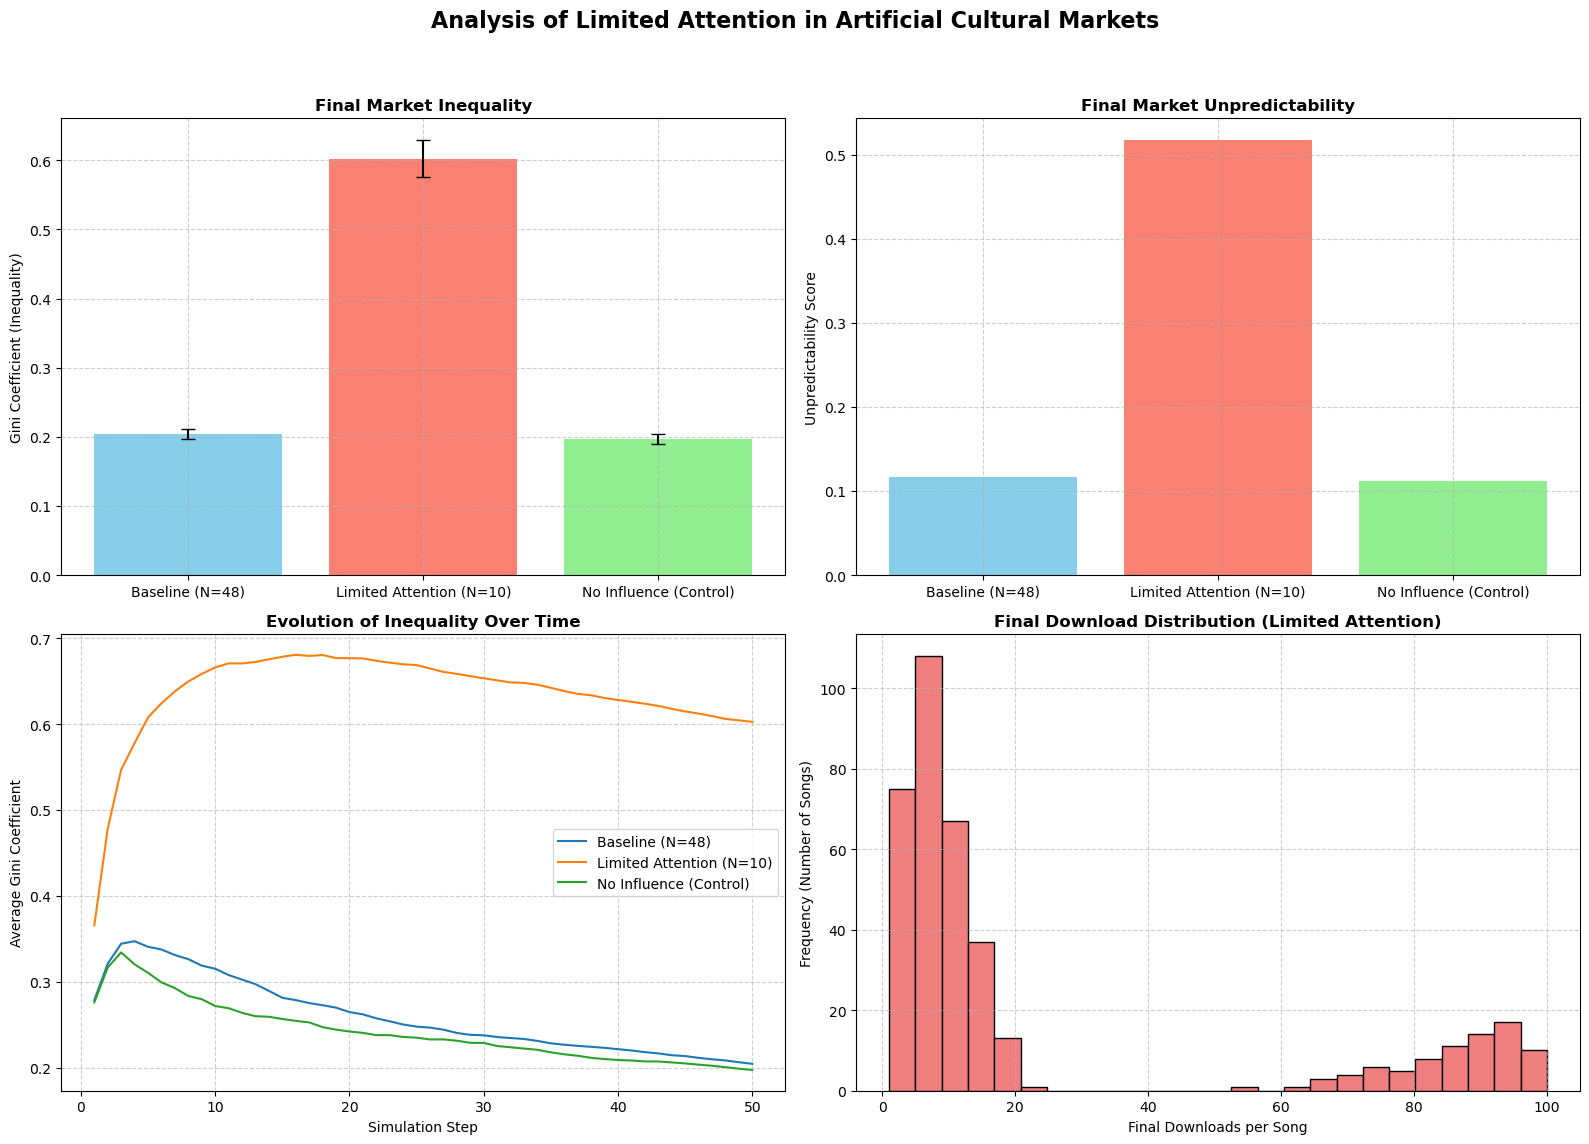

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import mesa
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector

DATA_DIR = r"/Users/Zhuanz1/Downloads/CSV"
FIGURE_OUTPUT_DIR = r"/Users/Zhuanz1/Desktop/Modeling/musiclab_data"
os.makedirs(FIGURE_OUTPUT_DIR, exist_ok=True)

NUM_LISTENERS = 100
SIMULATION_STEPS = 50
INFLUENCE_FACTOR = 0.1
INITIAL_CHOICE_PROBABILITY = 0.5
NUM_SIMULATIONS = 8 
ATTENTION_N = 10  
EXPLORATION_K = 2   

def load_initial_quality_abm(filepath, column_index):
    try:
        df = pd.read_csv(filepath, sep=",", header=None)
        quality_series = df.iloc[:, column_index]
        return {i: q for i, q in enumerate(pd.to_numeric(quality_series, errors='coerce').fillna(0).to_list())}
    except FileNotFoundError:
        print(f"ERROR: {filepath} not found for ABM initial quality.")
        return None

def calculate_gini(data):
    if not isinstance(data, (list, np.ndarray)) or len(data) == 0:
        return 0
    
    sorted_data = np.sort(np.array(data))
    n = len(data)
    if n == 0 or np.sum(sorted_data) == 0:
        return 0
    
    index = np.arange(1, n + 1)
    return (np.sum((2 * index - n - 1) * sorted_data)) / (n * np.sum(sorted_data))

def calculate_unpredictability_abm(all_final_downloads_list):
    if not all_final_downloads_list or len(all_final_downloads_list) < 2:
        return 0
        
    df = pd.DataFrame(all_final_downloads_list).fillna(0)
    
    market_share_df = df.div(df.sum(axis=1), axis=0)
    corr_matrix = market_share_df.T.corr(method='pearson')
    upper_tri_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    avg_corr = upper_tri_corr.stack().mean()
    
    return 1 - avg_corr if not np.isnan(avg_corr) else 0

def plot_gini_comparison(results_dict, ax):
    labels = list(results_dict.keys())
    gini_means = [np.mean(res['gini']) for res in results_dict.values()]
    gini_stds = [np.std(res['gini']) for res in results_dict.values()]
    
    ax.bar(labels, gini_means, yerr=gini_stds, capsize=5, color=['skyblue', 'salmon', 'lightgreen'])
    ax.set_ylabel("Gini Coefficient (Inequality)")
    ax.set_title("Final Market Inequality", fontsize=12, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.6)

def plot_unpredictability_comparison(results_dict, ax):
    labels = list(results_dict.keys())
    unpredictability_scores = [res['unpredictability'] for res in results_dict.values()]
    
    ax.bar(labels, unpredictability_scores, color=['skyblue', 'salmon', 'lightgreen'])
    ax.set_ylabel("Unpredictability Score")
    ax.set_title("Final Market Unpredictability", fontsize=12, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.6)

def plot_gini_over_time(results_dict, ax):
    for name, res in results_dict.items():
        ax.plot(range(1, SIMULATION_STEPS + 1), res['gini_over_time'][1:], label=name)
    ax.set_xlabel("Simulation Step")
    ax.set_ylabel("Average Gini Coefficient")
    ax.set_title("Evolution of Inequality Over Time", fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

def plot_final_distribution(final_downloads_list, ax, title):
    """Creates a histogram of the final download counts for all songs in all worlds."""
    all_counts = [count for run_downloads in final_downloads_list for count in run_downloads.values()]
    ax.hist(all_counts, bins=25, color='lightcoral', edgecolor='black')
    ax.set_xlabel("Final Downloads per Song")
    ax.set_ylabel("Frequency (Number of Songs)")
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.6)


class Listener(mesa.Agent):
    def __init__(self, unique_id, model, initial_quality_map, influence_factor, attention_n, exploration_k):
        super().__init__(unique_id, model)
        self.intrinsic_preference = initial_quality_map
        self.influence_factor = influence_factor
        self.downloaded_songs = set()
        self.attention_n = attention_n
        self.exploration_k = exploration_k

    def get_consideration_set(self):
        """ Implements the attention heuristic. """
        all_songs = list(self.model.initial_quality_map.keys())
        
        if self.attention_n >= len(all_songs):
            return all_songs
            
        sorted_songs = sorted(all_songs, key=lambda s: self.model.download_counts.get(s, 0), reverse=True)
        top_n_songs = sorted_songs[:self.attention_n]
        other_songs = sorted_songs[self.attention_n:]
        consideration_set = set(top_n_songs)
        
        if self.exploration_k > 0 and other_songs:
            num_to_sample = min(self.exploration_k, len(other_songs))
            exploration_songs = self.random.sample(other_songs, num_to_sample)
            consideration_set.update(exploration_songs)
            
        return list(consideration_set)

    def choose_song(self):
        consideration_set = self.get_consideration_set()
        if not consideration_set: return None
        
        probabilities = defaultdict(float)
        total_downloads_in_set = sum(self.model.download_counts.get(s, 0) for s in consideration_set) + 1e-9
        sum_intrinsic_qualities_in_set = sum(self.intrinsic_preference.get(s, 0) for s in consideration_set) + 1e-9

        for song_id in consideration_set:
            quality = self.intrinsic_preference.get(song_id, 0)
            downloads = self.model.download_counts.get(song_id, 0)
            preference_weight = quality / sum_intrinsic_qualities_in_set
            popularity_weight = downloads / total_downloads_in_set
            probabilities[song_id] = (1 - self.influence_factor) * preference_weight + self.influence_factor * popularity_weight
        
        total_prob = sum(probabilities.values())
        if total_prob == 0: return self.random.choice(consideration_set)
            
        normalized_probs = [v / total_prob for v in probabilities.values()]
        song_ids = list(probabilities.keys())
        
        return self.random.choices(song_ids, weights=normalized_probs, k=1)[0]

    def step(self):
        if self.random.random() < self.model.initial_choice_probability:
            song_to_download = self.choose_song()
            if song_to_download is not None and song_to_download not in self.downloaded_songs:
                self.downloaded_songs.add(song_to_download)
                self.model.download_counts[song_to_download] += 1

class MusicDownloadModel(mesa.Model):
    def __init__(self, num_listeners, initial_quality_map, influence_factor, choice_prob, attention_n, exploration_k):
        super().__init__()
        self.schedule = SimultaneousActivation(self)
        self.download_counts = defaultdict(int)
        self.initial_quality_map = initial_quality_map
        self.initial_choice_probability = choice_prob

        for i in range(num_listeners):
            listener = Listener(i, self, initial_quality_map, influence_factor, attention_n, exploration_k)
            self.schedule.add(listener)

        self.datacollector = DataCollector(
            model_reporters={"Gini": lambda m: calculate_gini(list(m.download_counts.values()))}
        )
        self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

def run_abm_simulation_set(initial_quality_map, num_listeners, sim_steps, influence_factor, choice_prob, num_sims, attention_n, exploration_k):
    all_final_downloads_for_set = []
    gini_values_for_set = []
    all_gini_over_time = []

    for _ in range(num_sims):
        model = MusicDownloadModel(num_listeners, initial_quality_map, influence_factor, choice_prob, attention_n, exploration_k)
        for _ in range(sim_steps):
            model.step()
        
        gini_df = model.datacollector.get_model_vars_dataframe()
        gini_values_for_set.append(gini_df["Gini"].iloc[-1])
        all_gini_over_time.append(gini_df["Gini"].tolist())
        all_final_downloads_for_set.append(dict(model.download_counts))
    
    avg_gini_over_time = np.mean(all_gini_over_time, axis=0)

    return {
        "gini": gini_values_for_set,
        "unpredictability": calculate_unpredictability_abm(all_final_downloads_for_set),
        "gini_over_time": avg_gini_over_time,
        "final_downloads": all_final_downloads_for_set
    }

if __name__ == "__main__":
    initial_quality_filepath = os.path.join(DATA_DIR, "downloads_v1_lexorder.txt")
    initial_quality_map = load_initial_quality_abm(initial_quality_filepath, 9)

    results = {}
    
    if initial_quality_map:
        print("Running Baseline (Unlimited Attention, N=48)")
        results['Baseline (N=48)'] = run_abm_simulation_set(
            initial_quality_map, NUM_LISTENERS, SIMULATION_STEPS, INFLUENCE_FACTOR,
            INITIAL_CHOICE_PROBABILITY, NUM_SIMULATIONS, attention_n=48, exploration_k=0
        )

        print("\nRunning Limited Attention (N=10, K=2)")
        results['Limited Attention (N=10)'] = run_abm_simulation_set(
            initial_quality_map, NUM_LISTENERS, SIMULATION_STEPS, INFLUENCE_FACTOR,
            INITIAL_CHOICE_PROBABILITY, NUM_SIMULATIONS, attention_n=ATTENTION_N, exploration_k=EXPLORATION_K
        )
        
        print("\nRunning No Social Influence Control")
        results['No Influence (Control)'] = run_abm_simulation_set(
            initial_quality_map, 
            NUM_LISTENERS, 
            SIMULATION_STEPS, 
            0,
            INITIAL_CHOICE_PROBABILITY, 
            NUM_SIMULATIONS, 
            attention_n=48, 
            exploration_k=0
        )

        print("\n--- Final Results ---")
        for name, res in results.items():
            print(f"Condition: {name}")
            print(f"  - Average Gini Coefficient: {np.mean(res['gini']):.4f} (Std: {np.std(res['gini']):.4f})")
            print(f"  - Unpredictability Score: {res['unpredictability']:.4f}")
       
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Analysis of Limited Attention in Artificial Cultural Markets', fontsize=16, fontweight='bold')
        
        plot_gini_comparison(results, axes[0, 0])
        plot_unpredictability_comparison(results, axes[0, 1])
        plot_gini_over_time(results, axes[1, 0])
        plot_final_distribution(
            results['Limited Attention (N=10)']['final_downloads'],
            axes[1, 1],
            title="Final Download Distribution (Limited Attention)")
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(fig_path)
        plt.show()